In [1]:
using Distributed
# @everywhere used for the implementation of the modules across multiple workers
# Without it, the code does not run

# Add the modules to the ´read´ path of the Julia
@everywhere push!(LOAD_PATH, "/scratch/users/vaydingul20/workfolder/COMP541_Project/src/modules/")
# Custom modules
@everywhere using Model: HapticNet, VisualNet, train_epoch!, save_as_jld2
@everywhere using TUM69: load_accel_data, load_image_data
@everywhere using Preprocess: process_accel_signal, process_image, augment_image
@everywhere using Utils: kfold, notify!, a_type
@everywhere using Metrics: confusion_matrix, visualize, confusion_params, accuracy_score
# Ready-to-use modules 
using JLD2, Random
using CUDA

notify!("Script started! -- hn")

# Set path
path = CUDA.functional() ? "/userfiles/vaydingul20/data/new" : "data/new" 
DATA_PATH = isdir(path) && path

#=
notify!("Data reading started! -- hn")
# Load data
X_train, y_train, _, _, material_dict = load_accel_data(DATA_PATH; mode = "normal")

notify!("Preprocessing started! -- hn")
# Apply preprocessing on the accelaration data
X_train, y_train = process_accel_signal(X_train, y_train)
# Seperate into 3 folds for training
kf = kfold(X_train, y_train; fold = 3, atype = a_type(Float32))
=#
# Initialization of the results vector that will be saved at the end of the training
results = []


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

{}

100    23  100     2  100    21      1     15  0:00:02  0:00:01  0:00:01    17


Any[]

In [2]:
JLD2.@load "/scratch/users/vaydingul20/workfolder/COMP541_Project/scripts/HapticNet_experiments/10fold.jld2" kf

notify!("Training started! -- hn")
dtst1 = kf.folds[1][2] 
dtst2 = kf.folds[2][2]
dtst3 = kf.folds[3][2]
dtst4 = kf.folds[4][2]
dtst5 = kf.folds[5][2]
dtst6 = kf.folds[6][2]
dtst7 = kf.folds[7][2]
dtst8 = kf.folds[8][2]
dtst9 = kf.folds[9][2]
dtst10 = kf.folds[10][2]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    23    0     0  100    23      0      5  0:00:04  0:00:04 --:--:--     5

{}

100    25    0     2  100    23      0      4  0:00:05  0:00:04  0:00:01     5


4-element Knet.Train20.Data{Tuple{Knet.KnetArrays.KnetArray{Float32,N} where N,Array{Int8,N} where N}}

In [3]:
# Reset model
#hn = HapticNet(; atype = a_type(Float32), lrn = false)
hn1 = HapticNet("/scratch/users/vaydingul20/workfolder/hn-1-5.jld2")
hn2 = HapticNet("/scratch/users/vaydingul20/workfolder/hn-2-5.jld2")
hn3 = HapticNet("/scratch/users/vaydingul20/workfolder/hn-3-5.jld2")
hn4 = HapticNet("/scratch/users/vaydingul20/workfolder/hn-4-5.jld2")
hn5 = HapticNet("/scratch/users/vaydingul20/workfolder/hn-5-5.jld2")
hn6 = HapticNet("/scratch/users/vaydingul20/workfolder/hn-6-5.jld2")
hn7 = HapticNet("/scratch/users/vaydingul20/workfolder/hn-7-5.jld2")
hn8 = HapticNet("/scratch/users/vaydingul20/workfolder/hn-8-5.jld2")
hn9 = HapticNet("/scratch/users/vaydingul20/workfolder/hn-9-5.jld2")
hn10 = HapticNet("/scratch/users/vaydingul20/workfolder/hn-10-5.jld2")


HapticNet(Model.GCN((Model.Conv(P(Knet.KnetArrays.KnetArray{Float32,4}(3,3,1,50)), P(Knet.KnetArrays.KnetArray{Float32,4}(1,1,50,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), (2, 2), false, Knet.KnetArrays.KnetArray{Float32,N} where N), Model.Conv(P(Knet.KnetArrays.KnetArray{Float32,4}(3,3,50,100)), P(Knet.KnetArrays.KnetArray{Float32,4}(1,1,100,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), (2, 2), false, Knet.KnetArrays.KnetArray{Float32,N} where N), Model.Conv(P(Knet.KnetArrays.KnetArray{Float32,4}(3,3,100,150)), P(Knet.KnetArrays.KnetArray{Float32,4}(1,1,150,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), (2, 2), false, Knet.KnetArrays.KnetArray{Float32,N} where N), Model.Conv(P(Knet.KnetArrays.KnetArray{Float32,4}(3,3,150,200)), P(Knet.KnetArrays.KnetArray{Float32,4}(1,1,200,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), (2, 2), false, Knet.KnetArrays.KnetArray{Float32,N} where N), Model.Conv(P(Knet.KnetArrays.KnetArray{Float32,4}(4,12,200,400)), P(Knet.KnetArrays.KnetArra

In [4]:
using Knet: Data, mat
function _predict4(x)
    #= 
    This function execute following processes:
        - It calculates accuracy of the model for given x and y value
        - If average == true, then it gives directly the accuracy,
            if it is not, then it gives correct number of predictions and total count as 
            2-element Tuple.
      
    Usage:
        _accuracy4(x, y)

    Input:
        x = Output of the network, dense prediction as 4D tensor
        y = True label of the corresponding x
    

    Output:
        _accuracy = Calculated accuracy
        or
        (correct_pred, total_count) = Number of correct predictions and total count as 
            2-element Tuple. =#

    x = permutedims(x, (3, 1, 2, 4))
    sc, sx, sy, sn = size(x)
    pred = vcat([max_vote_(mat(x[:,:,:,k], dims=1)) for k in 1:sn]...)

end



function predict4(model; data::Data)

    #= 
    This function execute following processes:
        - It calculates accuracy of the model per batch for given model and Data object
        - 
    Usage:
        accuracy4(model; data = test_set)

    Input:
        model = Network model to be evaluated
        data = Batch to be processed in model
    

    Output:
        accuracy = Calculated accuracy =#
    


    preds = vcat([_predict4(model(x)) for (x, _) in data]...)
   


    return preds
end

function max_vote_(y)
    y = getindex.(argmax(y, dims=1), 1)
    u = unique(y)
    d = Dict([(i, count(x -> x == i, y)) for i in u])
    argmax(d)
    
    # mode(y)
end




max_vote_ (generic function with 1 method)

In [5]:
cms = zeros(69,69)    

pred = []
    ygold = []
    for (x,y) in dtst1
        push!(pred, _predict4(hn1.model(x)))
        push!(ygold, y)
    end
    pred = convert(Array{Int},vcat(pred...))
    ygold = convert(Array{Int},vcat(ygold...))
cms .+= size(confusion_matrix(pred, ygold).matrix) != (68,68) ? confusion_matrix(pred, ygold).matrix : zeros(69,69)

pred = []
    ygold = []
for (x,y) in dtst2
        push!(pred, _predict4(hn2.model(x)))
        push!(ygold, y)
    end
    pred = convert(Array{Int},vcat(pred...))
    ygold = convert(Array{Int},vcat(ygold...))

cms .+= size(confusion_matrix(pred, ygold).matrix) != (68,68) ? confusion_matrix(pred, ygold).matrix : zeros(69,69)

pred = []
    ygold = []
for (x,y) in dtst3
        push!(pred, _predict4(hn3.model(x)))
        push!(ygold, y)
    end
    pred = convert(Array{Int},vcat(pred...))
    ygold = convert(Array{Int},vcat(ygold...))
cms .+= size(confusion_matrix(pred, ygold).matrix) != (68,68) ? confusion_matrix(pred, ygold).matrix : zeros(69,69)
pred = []
    ygold = []
for (x,y) in dtst4
        push!(pred, _predict4(hn4.model(x)))
        push!(ygold, y)
    end
    pred = convert(Array{Int},vcat(pred...))
    ygold = convert(Array{Int},vcat(ygold...))
cms .+= size(confusion_matrix(pred, ygold).matrix) != (68,68) ? confusion_matrix(pred, ygold).matrix : zeros(69,69)
pred = []
    ygold = []
for (x,y) in dtst6
        push!(pred, _predict4(hn6.model(x)))
        push!(ygold, y)
    end
    pred = convert(Array{Int},vcat(pred...))
    ygold = convert(Array{Int},vcat(ygold...))
cms .+= size(confusion_matrix(pred, ygold).matrix) != (68,68) ? confusion_matrix(pred, ygold).matrix : zeros(69,69)
pred = []
    ygold = []
for (x,y) in dtst7
        push!(pred, _predict4(hn7.model(x)))
        push!(ygold, y)
    end
    pred = convert(Array{Int},vcat(pred...))
    ygold = convert(Array{Int},vcat(ygold...))
cms .+= size(confusion_matrix(pred, ygold).matrix) != (68,68) ? confusion_matrix(pred, ygold).matrix : zeros(69,69)
pred = []
    ygold = []
for (x,y) in dtst8
        push!(pred, _predict4(hn8.model(x)))
        push!(ygold, y)
    end
    pred = convert(Array{Int},vcat(pred...))
    ygold = convert(Array{Int},vcat(ygold...))
cms .+= size(confusion_matrix(pred, ygold).matrix) != (68,68) ? confusion_matrix(pred, ygold).matrix : zeros(69,69)
pred = []
    ygold = []
for (x,y) in dtst9
        push!(pred, _predict4(hn9.model(x)))
        push!(ygold, y)
    end
    pred = convert(Array{Int},vcat(pred...))
    ygold = convert(Array{Int},vcat(ygold...))
cms .+= size(confusion_matrix(pred, ygold).matrix) != (68,68) ? confusion_matrix(pred, ygold).matrix : zeros(69,69)

    pred = []
    ygold = []
    for (x,y) in dtst10
        push!(pred, _predict4(hn10.model(x)))
        push!(ygold, y)
    end
    pred = convert(Array{Int},vcat(pred...))
    ygold = convert(Array{Int},vcat(ygold...))
cms .+= size(confusion_matrix(pred, ygold).matrix) != (68,68) ? confusion_matrix(pred, ygold).matrix : zeros(69,69)


┌ Warning: No labels provided, constructing a label set by union of the unique elements in Expected and Predicted arrays
└ @ Metrics /scratch/users/vaydingul20/workfolder/COMP541_Project/src/modules/metrics/metric_ops.jl:188
┌ Warning: There are elements of value 0 in the true positives array. This may lead to false values for some functions
└ @ Metrics /scratch/users/vaydingul20/workfolder/COMP541_Project/src/modules/metrics/metric_ops.jl:207
┌ Warning: There are elements of value 0 in the false positives array. This may lead to false values for some functions
└ @ Metrics /scratch/users/vaydingul20/workfolder/COMP541_Project/src/modules/metrics/metric_ops.jl:213
┌ Warning: There are elements of value 0 in the false negatives array. This may lead to false values for some functions
└ @ Metrics /scratch/users/vaydingul20/workfolder/COMP541_Project/src/modules/metrics/metric_ops.jl:216
┌ Warning: No labels provided, constructing a label set by union of the unique elements in Expected and 

┌ Warning: No labels provided, constructing a label set by union of the unique elements in Expected and Predicted arrays
└ @ Metrics /scratch/users/vaydingul20/workfolder/COMP541_Project/src/modules/metrics/metric_ops.jl:188
┌ Warning: There are elements of value 0 in the true positives array. This may lead to false values for some functions
└ @ Metrics /scratch/users/vaydingul20/workfolder/COMP541_Project/src/modules/metrics/metric_ops.jl:207
┌ Warning: There are elements of value 0 in the false positives array. This may lead to false values for some functions
└ @ Metrics /scratch/users/vaydingul20/workfolder/COMP541_Project/src/modules/metrics/metric_ops.jl:213
┌ Warning: There are elements of value 0 in the false negatives array. This may lead to false values for some functions
└ @ Metrics /scratch/users/vaydingul20/workfolder/COMP541_Project/src/modules/metrics/metric_ops.jl:216
┌ Warning: No labels provided, constructing a label set by union of the unique elements in Expected and 

69×69 Array{Float64,2}:
 41.0   1.0   4.0   3.0   1.0   3.0  …   1.0  11.0   6.0   2.0   4.0   2.0
  0.0  41.0   0.0   0.0   1.0   0.0      1.0   0.0   4.0   0.0   0.0   0.0
  5.0   0.0  48.0   0.0   1.0   0.0      0.0   0.0   1.0   0.0   0.0   0.0
  0.0   0.0   0.0  22.0   0.0   0.0      0.0   0.0   2.0   2.0   0.0   2.0
  0.0   0.0   0.0   0.0  33.0   7.0      0.0   0.0   0.0   0.0   0.0   1.0
  5.0   0.0   0.0   0.0   6.0  27.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   1.0   1.0   0.0      0.0   0.0   0.0   0.0   0.0   2.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  1.0   0.0   0.0   0.0   0.0   2.0      0.0   0.0   1.0   0.0   1.0   0.0
  0.0   0.0   0.0   1.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 

In [59]:
cms = cms./10

69×69 Array{Float64,2}:
 1.6  0.2  0.1  0.1  0.0  0.3  0.0  0.0  …  0.1  0.0  0.5  0.2  0.1  0.2  0.0
 0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.1  0.0  3.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.1  0.0  0.0  0.0
 0.0  0.0  0.0  0.7  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.1  0.0  0.0  0.1
 0.1  0.0  0.0  0.0  1.1  0.2  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.1
 0.1  0.0  0.0  0.0  0.0  1.1  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.1  0.0  1.1  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.1     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.2  0.0  0.0     0.0  0.0  0.0  0.1  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.1  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [63]:
cms = ceil.(Int, cms)

69×69 Array{Int64,2}:
 40   1   3   2   3   4   5   4  10  …   2   2   3   0  10   9   3   5   0
  0  41   0   0   0   0   0   0   0      0   0   0   1   0   2   0   0   0
  2   0  53   0   1   0   0   0   0      0   0   0   0   0   1   0   0   0
  0   1   0  19   0   0   0   0   0      0   2   0   0   1   3   2   0   1
  1   0   0   0  31   3   1   0   0      0   0   0   0   0   0   0   0   1
  2   0   0   0   6  23   0   0   2  …   0   0   0   0   0   0   0   0   0
  0   0   0   1   1   0  15   0   0      0   1   1   0   0   0   0   0   0
  0   0   0   0   0   0   0  46   0      0   0   0   0   0   0   0   0   0
  0   0   0   0   0   3   0   0  25      0   0   0   0   0   1   0   0   1
  0   0   0   1   0   0   0   3   0      0   1   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0  …   0   0   0   0   1   0   0   0   0
  0   0   0   0   0   0   0   1   0      0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
  ⋮

In [6]:
p1,p2,p3,p4 = confusion_params(convert(Array{Number},cms))
cm_  = confusion_matrix(p1,p2,p3,p4, cms, collect(1:69), "warn")

                                                                                                                                                                                                                                                                               Expected

       1       2       3       4       5       6       7       8       9      10      11      12      13      14      15      16      17      18      19      20      21      22      23      24      25      26      27      28      29      30      31      32      33      34      35      36      37      38      39      40      41      42      43      44      45      46      47      48      49      50      51      52      53      54      55      56      57      58      59      60      61      62      63      64      65      66      67      68      69
______________________________________________________________________________________________________________________________________________________________________

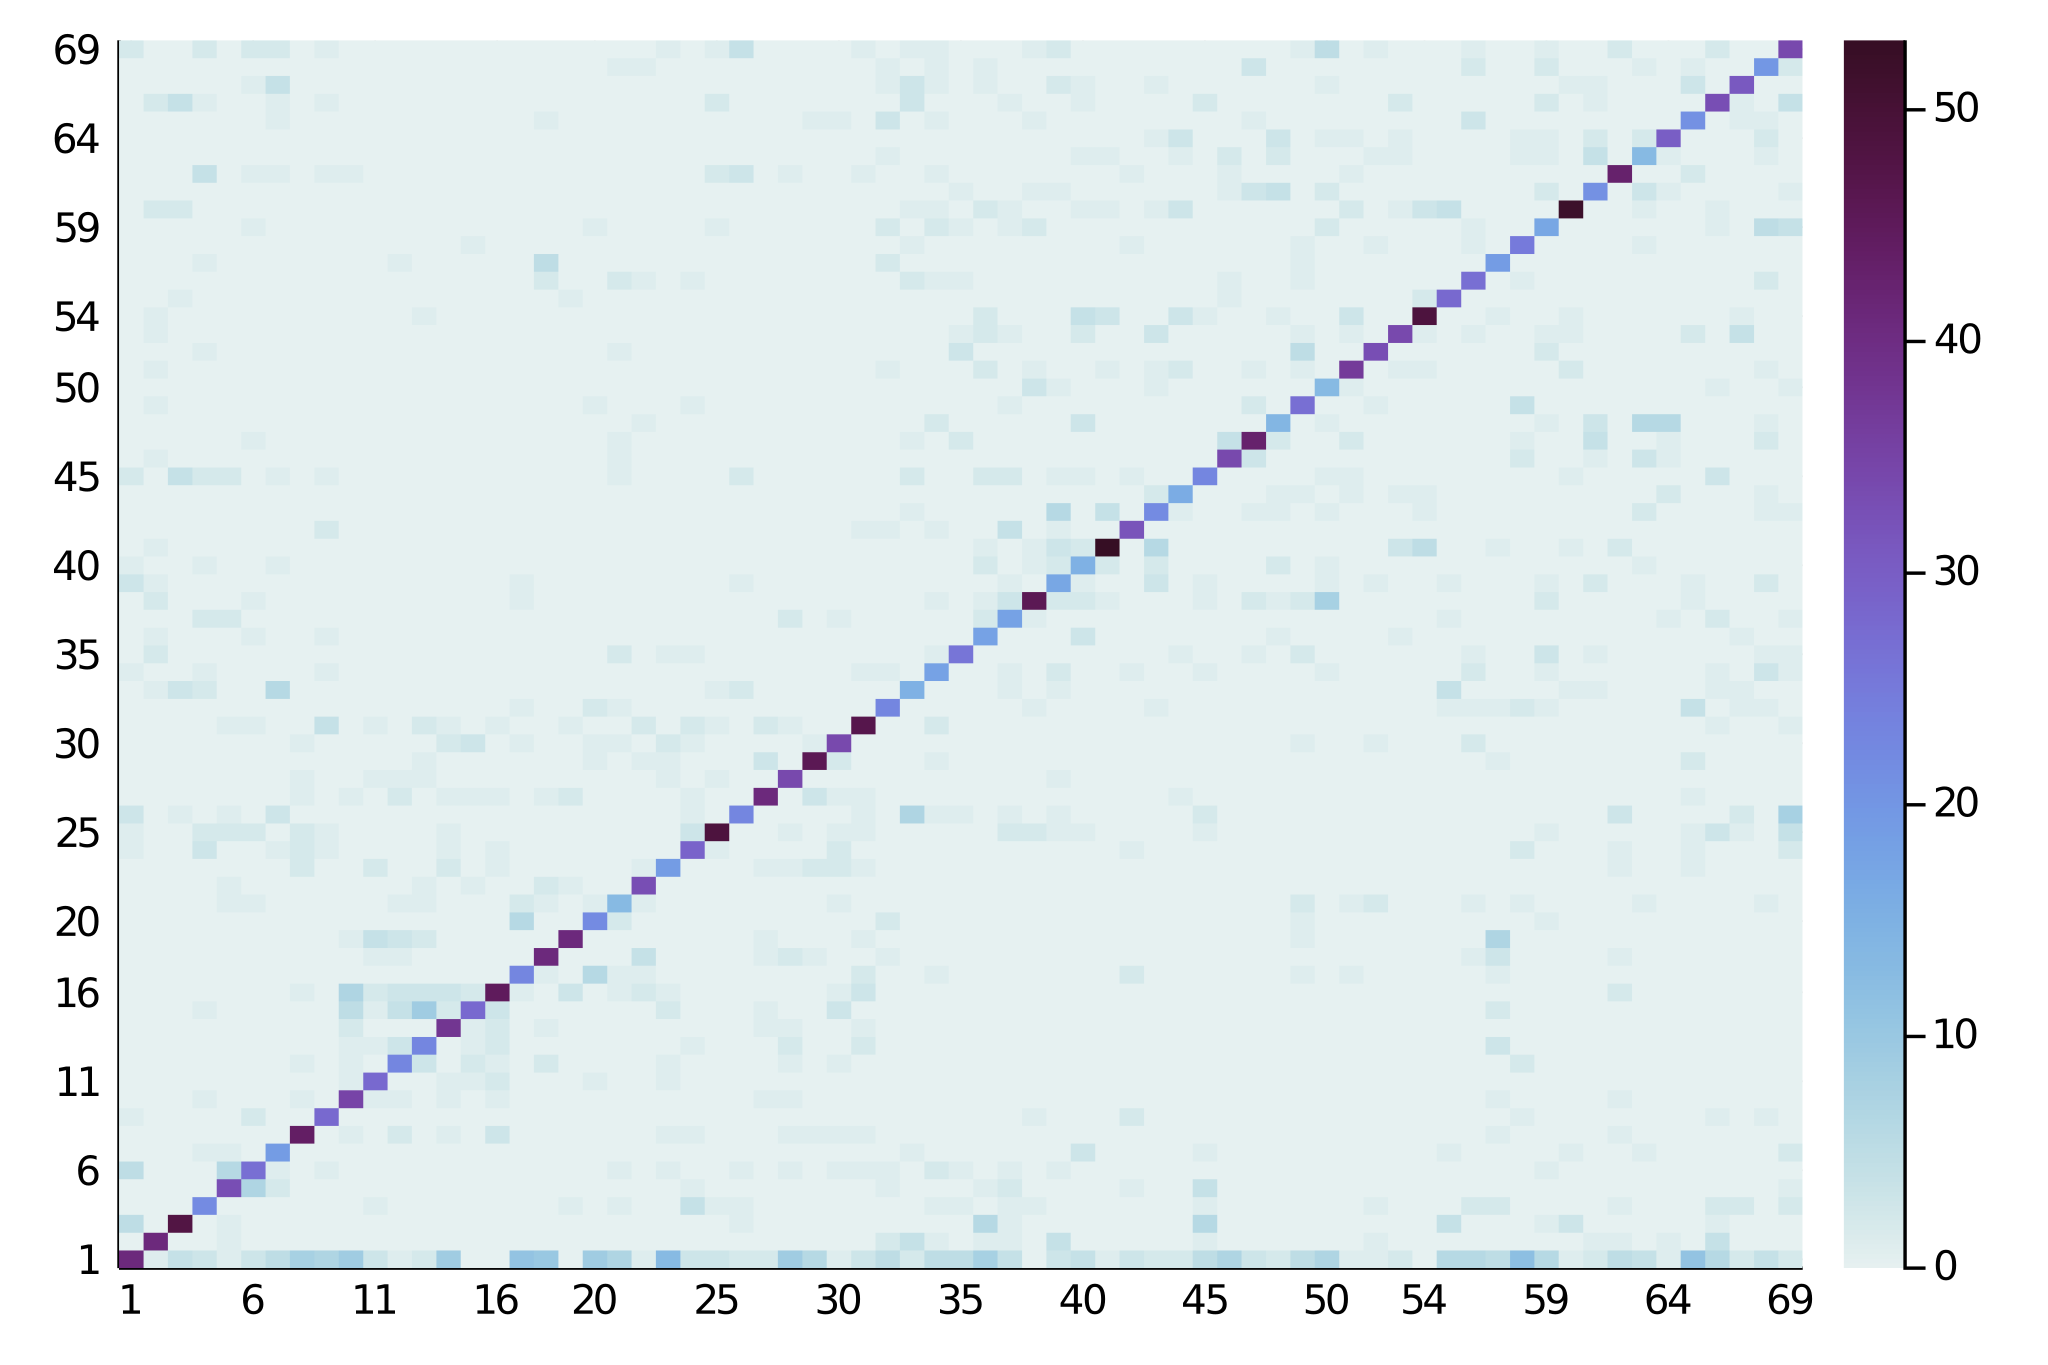

In [8]:
using Plots: gr, savefig, histogram, bar
gr()
savefig(visualize(cm_), "asd2.png")
visualize(cm_)

In [9]:
accuracy_score(cm_)

0.018927623456790117

In [10]:
using LinearAlgebra
accsc = [(cms[k,k])./(sum(cms[k, :]) + sum(cms[:, k]) - cms[k, k]) for k in 1:69]
savefig(bar(accsc;xlabel="Material Type", ylabel = "Accuracy", label = ""), "bar.png")

In [35]:
@everywhere using Network: accuracy4

In [40]:
accuracy4(hn3.model; data = dtst3)

0.6125

In [12]:
for (x, y) in dtrn
    @show _predict4(hn.model(x))
end

LoadError: UndefVarError: dtrn not defined

In [13]:
predict4(hn.model; data = dtrn)

LoadError: UndefVarError: dtrn not defined

In [14]:
accuracy4(hn.model, data = dtrn)

LoadError: UndefVarError: dtrn not defined